# Optimizers

In [1]:
import numpy as np
from tqdm import tqdm
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

# Generate spiral dataset
X, y = spiral_data(samples=100, classes=3)

## Layer and Activation classes

In [2]:
class Layer_Dense:
    def __init__(self,n_inputs,n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases
        
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)
        
class Activation_RELU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
class Activation_Softmax:
    def forward(self,inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
        self.output = exp_values / np.sum(exp_values,axis=1,keepdims=True)
        
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues) 

## Loss Classes

In [3]:
class Loss:
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred,1e-7,1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples
        
class Activation_Softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        self.dinputs = self.dinputs / samples

## Optimizer Classes

In [4]:
class Optimizer_SGD:
    def __init__(self,learning_rate=1.,decay=0.,momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self,layer):
        if self.momentum:
            if not hasattr(layer,'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            # past - future direction
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iterations += 1  


In [5]:
class Optimizer_Adagrad:
    def __init__(self,learning_rate=1.,decay=0.,epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / np.sqrt(layer.bias_cache) + self.epsilon
    
    def post_update_params(self):
        self.iterations += 1

In [6]:
class Optimizer_RMSprop:
    def __init__(self,learning_rate=0.001,decay=0.,epsilon=1e-7,rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
            
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + ( 1 - self.rho) * layer.dbiases ** 2
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

In [7]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

## Model Training

In [9]:
dense1 = Layer_Dense(2, 64)
activation1 = Activation_RELU()
dense2 = Layer_Dense(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
epoches = []
accuracies = []
losses = []
learning_rates = []

# Training loop
for epoch in tqdm(range(5001),desc="Training the model"):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    # Print progress every 100 epochs
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
        epoches.append(epoch)
        accuracies.append(accuracy)
        losses.append(loss)
        learning_rates.append(optimizer.current_learning_rate)
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update parameters
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

Training the model:   3%|▎         | 170/5001 [00:00<00:02, 1692.82it/s]

epoch: 0, acc: 0.410, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.757, loss: 0.649, lr: 0.04999752512250644
epoch: 200, acc: 0.827, loss: 0.466, lr: 0.04999502549496326
epoch: 300, acc: 0.853, loss: 0.374, lr: 0.049992526117345455


Training the model:  13%|█▎        | 675/5001 [00:00<00:02, 1606.78it/s]

epoch: 400, acc: 0.870, loss: 0.316, lr: 0.04999002698961558
epoch: 500, acc: 0.870, loss: 0.288, lr: 0.049987528111736124
epoch: 600, acc: 0.913, loss: 0.252, lr: 0.049985029483669646
epoch: 700, acc: 0.910, loss: 0.236, lr: 0.049982531105378675


Training the model:  21%|██        | 1032/5001 [00:00<00:02, 1628.81it/s]

epoch: 800, acc: 0.927, loss: 0.222, lr: 0.04998003297682575
epoch: 900, acc: 0.917, loss: 0.207, lr: 0.049977535097973466
epoch: 1000, acc: 0.940, loss: 0.195, lr: 0.049975037468784345
epoch: 1100, acc: 0.937, loss: 0.185, lr: 0.049972540089220974


Training the model:  28%|██▊       | 1384/5001 [00:00<00:02, 1695.96it/s]

epoch: 1200, acc: 0.820, loss: 0.526, lr: 0.04997004295924593
epoch: 1300, acc: 0.937, loss: 0.175, lr: 0.04996754607882181
epoch: 1400, acc: 0.947, loss: 0.170, lr: 0.049965049447911185
epoch: 1500, acc: 0.947, loss: 0.166, lr: 0.04996255306647668


Training the model:  37%|███▋      | 1867/5001 [00:01<00:02, 1521.28it/s]

epoch: 1600, acc: 0.947, loss: 0.163, lr: 0.049960056934480884
epoch: 1700, acc: 0.947, loss: 0.160, lr: 0.04995756105188642
epoch: 1800, acc: 0.947, loss: 0.157, lr: 0.049955065418655915
epoch: 1900, acc: 0.947, loss: 0.154, lr: 0.04995257003475201


Training the model:  44%|████▍     | 2204/5001 [00:01<00:01, 1592.71it/s]

epoch: 2000, acc: 0.950, loss: 0.151, lr: 0.04995007490013731
epoch: 2100, acc: 0.950, loss: 0.148, lr: 0.0499475800147745
epoch: 2200, acc: 0.947, loss: 0.145, lr: 0.0499450853786262
epoch: 2300, acc: 0.947, loss: 0.142, lr: 0.0499425909916551


Training the model:  51%|█████     | 2546/5001 [00:01<00:01, 1570.77it/s]

epoch: 2400, acc: 0.950, loss: 0.140, lr: 0.04994009685382384
epoch: 2500, acc: 0.950, loss: 0.137, lr: 0.04993760296509512
epoch: 2600, acc: 0.950, loss: 0.134, lr: 0.049935109325431604


Training the model:  57%|█████▋    | 2858/5001 [00:01<00:01, 1503.83it/s]

epoch: 2700, acc: 0.950, loss: 0.132, lr: 0.049932615934796004
epoch: 2800, acc: 0.953, loss: 0.130, lr: 0.04993012279315098
epoch: 2900, acc: 0.957, loss: 0.128, lr: 0.049927629900459285


Training the model:  63%|██████▎   | 3152/5001 [00:02<00:01, 1217.29it/s]

epoch: 3000, acc: 0.957, loss: 0.126, lr: 0.049925137256683606
epoch: 3100, acc: 0.957, loss: 0.124, lr: 0.04992264486178666


Training the model:  69%|██████▉   | 3472/5001 [00:02<00:01, 1357.06it/s]

epoch: 3200, acc: 0.953, loss: 0.133, lr: 0.04992015271573119
epoch: 3300, acc: 0.953, loss: 0.123, lr: 0.04991766081847992
epoch: 3400, acc: 0.957, loss: 0.121, lr: 0.049915169169995596
epoch: 3500, acc: 0.960, loss: 0.120, lr: 0.049912677770240964


Training the model:  76%|███████▋  | 3814/5001 [00:02<00:00, 1508.08it/s]

epoch: 3600, acc: 0.960, loss: 0.118, lr: 0.049910186619178794
epoch: 3700, acc: 0.960, loss: 0.117, lr: 0.04990769571677183
epoch: 3800, acc: 0.960, loss: 0.115, lr: 0.04990520506298287
epoch: 3900, acc: 0.960, loss: 0.114, lr: 0.04990271465777467


Training the model:  86%|████████▋ | 4322/5001 [00:02<00:00, 1615.49it/s]

epoch: 4000, acc: 0.963, loss: 0.112, lr: 0.049900224501110035
epoch: 4100, acc: 0.967, loss: 0.111, lr: 0.04989773459295174
epoch: 4200, acc: 0.820, loss: 0.579, lr: 0.04989524493326262
epoch: 4300, acc: 0.953, loss: 0.113, lr: 0.04989275552200545


Training the model:  93%|█████████▎| 4648/5001 [00:03<00:00, 1420.14it/s]

epoch: 4400, acc: 0.953, loss: 0.111, lr: 0.04989026635914307
epoch: 4500, acc: 0.957, loss: 0.109, lr: 0.04988777744463829
epoch: 4600, acc: 0.960, loss: 0.108, lr: 0.049885288778453954


Training the model: 100%|██████████| 5001/5001 [00:03<00:00, 1504.37it/s]

epoch: 4700, acc: 0.963, loss: 0.107, lr: 0.049882800360552884
epoch: 4800, acc: 0.963, loss: 0.106, lr: 0.04988031219089794
epoch: 4900, acc: 0.963, loss: 0.105, lr: 0.049877824269451976
epoch: 5000, acc: 0.963, loss: 0.104, lr: 0.04987533659617785


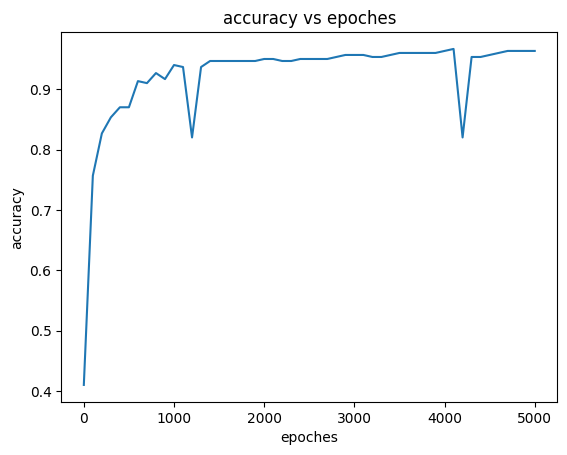

In [10]:
import matplotlib.pyplot as plt

def plot_line_chart(x,y,title,x_label,y_label):
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

x = epoches
y = accuracies
plot_line_chart(x,y,"accuracy vs epoches","epoches","accuracy")

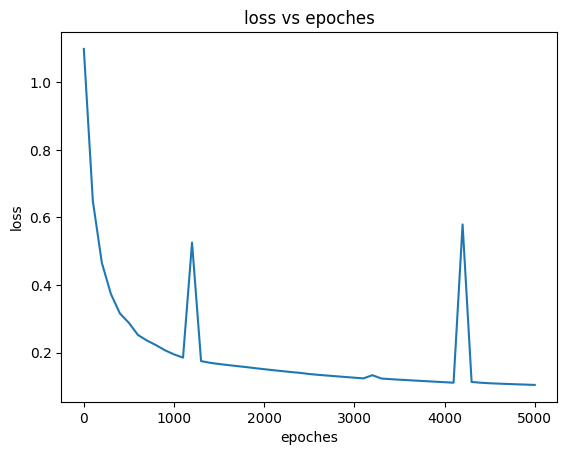

In [11]:
y = losses
plot_line_chart(x,y,"loss vs epoches","epoches","loss")

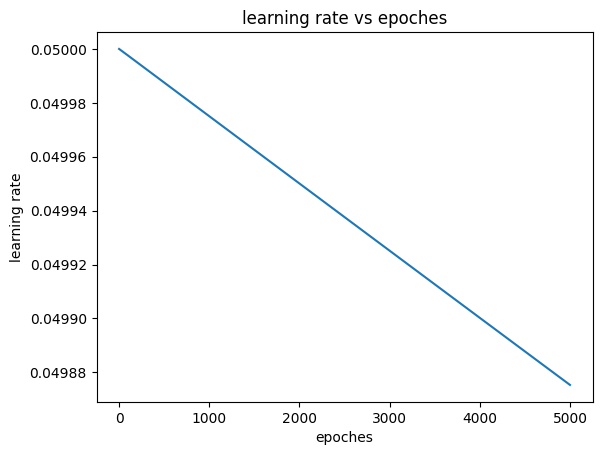

In [12]:
y = learning_rates
plot_line_chart(x,y,"learning rate vs epoches","epoches","learning rate")